In [75]:
from utils.lang_maps import HR_MAP 
from utils.task_vectors import TaskVector
from transformers import WhisperForConditionalGeneration
models_dir = "output_whisper-tiny"
ALL_LANGS = list(set(HR_MAP.keys()).union(set("_".join(v) for v in HR_MAP.values())))
TVs = {}
for lang in ALL_LANGS:
    if lang != "":
        TVs[lang] = TaskVector(
            pretrained_model=WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny"),
            finetuned_model=WhisperForConditionalGeneration.from_pretrained(f"{models_dir}/{lang}/final")
        )


In [ ]:
import pandas as pd
import json
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import torch
model = "results/whisper-tiny"
rows = []
summary_df = pd.read_csv(f"{model}/summary.csv")
lang_hr_gains = {}
for result in os.listdir(f"{model}/hyperparameters"):
    with open(f"{model}/hyperparameters/" + result, "r") as f:
        hyps = json.load(f)
        f.close()
    if len(hyps) > 0:
        lang_name = result.split(".")[0]
        lang_hr_gains[lang_name] = {}
        best_score = min(hyps.values())
        best_lambda = min(hyps, key=hyps.get)
        score_0 = hyps["0.0"]
        lang_hr_gains[lang_name]["lambda"] = best_lambda
        lang_hr_gains[lang_name]["hr_delta"] = abs(score_0 - best_score)
        language_tv = TVs[lang_name]
        hr_tv = TVs["_".join(HR_MAP[lang_name])]
        cossim = cosine_similarity(language_tv.tv_to_vector().reshape(1, -1), hr_tv.tv_to_vector().reshape(1, -1))[0][0]
        # Calculate the element-wise difference
        difference = [language_tv.vector[k] - hr_tv.vector[k] for k in language_tv.vector.keys()] 
        # Square each element of the difference matrix
        squared_difference = [np.square(d.flatten()) for d in difference]
        # Calculate the mean of all elements in the squared_difference matrix
        mse = np.mean(torch.cat(squared_difference).numpy())
        layer_wise_mse = [np.mean(l.numpy()) for l in squared_difference]
        lang_hr_gains[lang_name]["cosine_sim"] = cossim
        lang_hr_gains[lang_name]["mse"] = mse
        lang_hr_gains[lang_name]["layer_wise_mse"] = layer_wise_mse
        lang_hr_gains[lang_name]["wer"] = best_score



In [67]:
df = pd.DataFrame(lang_hr_gains).T
df

,lambda,hr_delta,cosine_sim,mse,layer_wise_mse,wer
rwm,0.03378863811999887,0.039316,0.101265,0.000289,"[2.205759e-05, 5.8241287e-05, 4.2103584e-05, 2...",0.782622
bew,0.436308948870678,0.107666,0.228761,0.000034,"[2.758683e-06, 3.1120874e-06, 3.865313e-06, 1....",0.748596
koo,0.1558817920436369,0.054721,0.127657,0.00029,"[2.0434016e-05, 4.8198563e-05, 4.1991585e-05, ...",0.857588
hch,0.15515734699049857,0.048941,0.459649,0.000028,"[2.2468603e-06, 3.0037907e-06, 3.6068918e-06, ...",0.8511
ady,0.04022445861816864,0.007309,0.463989,0.00009,"[2.9901541e-05, 8.362203e-05, 6.071063e-05, 3....",0.7991
aln,0.0351300872862339,0.018653,0.517629,0.000024,"[3.038547e-06, 2.560898e-06, 5.358011e-06, 1.5...",0.728949
cgg,0.21093589471308438,0.075202,0.119722,0.000287,"[2.094964e-05, 5.1487237e-05, 4.151314e-05, 2....",0.61029
mmc,0.1588065454594033,0.098074,0.382418,0.000036,"[3.1394256e-06, 6.400636e-06, 5.793643e-06, 3....",0.824684
ush,0.14255016966578468,0.021054,0.73058,0.000059,"[1.1329975e-05, 2.4427542e-05, 2.1341533e-05, ...",0.602577
el-CY,0.11710001205757978,0.025157,0.776042,0.000017,"[4.5665365e-06, 6.2655968e-06, 8.2156785e-06, ...",0.827242


In [68]:
df.drop('layer_wise_mse', axis=1).corr()

,lambda,hr_delta,cosine_sim,mse,wer
lambda,1.000000,0.695350,0.102441,-0.182847,-0.197844
hr_delta,0.695350,1.000000,-0.214252,0.113722,0.146819
cosine_sim,0.102441,-0.214252,1.000000,-0.846192,-0.096647
mse,-0.182847,0.113722,-0.846192,1.000000,0.065700
wer,-0.197844,0.146819,-0.096647,0.065700,1.000000


In [69]:
len(lang_hr_gains["kbd"]["layer_wise_mse"]), len(lang_hr_gains["ukv"]["layer_wise_mse"])


(168, 168)

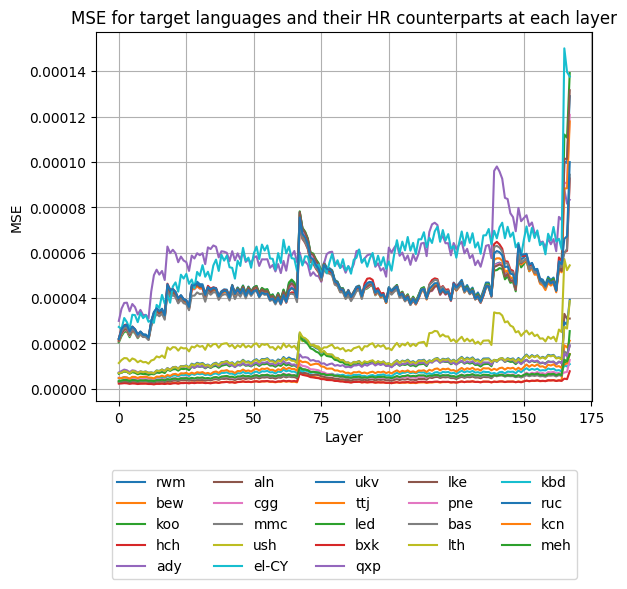

In [70]:
import matplotlib.pyplot as plt
# Plotting all lines at once
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed
mse_graph = [(lang, item["layer_wise_mse"]) for lang, item in lang_hr_gains.items()]
xs = range(len(mse_graph[0][1]))
ys = np.array([smooth(v[1], 0.9) for v in mse_graph]).T
labels = [v[0] for v in mse_graph]

fig, ax = plt.subplots()

ax.plot(xs, ys, label=labels)

# Adding labels and legend (you would need to manually create labels here if desired)
ax.set_xlabel('Layer')
ax.set_ylabel('MSE')
# ax.set_yscale("log")
ax.set_title('MSE for target languages and their HR counterparts at each layer')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=5) 
ax.grid(True)
plt.show()


In [ ]:
import pandas as pd
import json
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import torch
model = "results/whisper-tiny"
rows = []
summary_df = pd.read_csv(f"{model}/summary.csv")
lang_hr_gains = {}
for result in os.listdir(f"{model}/hyperparameters"):
    with open(f"{model}/hyperparameters/" + result, "r") as f:
        hyps = json.load(f)
        f.close()
    if len(hyps) > 0:
        lang_name = result.split(".")[0]
        lang_hr_gains[lang_name] = {}
        best_score = min(hyps.values())
        best_lambda = min(hyps, key=hyps.get)
        score_0 = hyps["0.0"]
        lang_hr_gains[lang_name]["lambda"] = best_lambda
        lang_hr_gains[lang_name]["hr_delta"] = abs(score_0 - best_score)
        language_tv = TVs[lang_name]
        hr_tv = TVs["_".join(HR_MAP[lang_name])]
        # Calculate the element-wise difference
        lr_layerwise, layer_strs = language_tv.tv_to_layer_wise()
        hr_layerwise, _ = hr_tv.tv_to_layer_wise()
        cossim_layerwise = [cosine_similarity(lr_layerwise[i].reshape(1, -1), hr_layerwise[i].reshape(1, -1))[0][0] for i in range(len(lr_layerwise))]
        difference = [np.array(lr_layerwise[i]) - np.array(hr_layerwise[i]) for i in range(len(lr_layerwise))]
        # Square each element of the difference matrix
        squared_difference = [np.square(d) for d in difference]
        # Calculate the mean of all elements in the squared_difference matrix
        layer_wise_mse = [np.mean(l) for l in squared_difference]
        lang_hr_gains[lang_name]["cosine_sim"] = np.mean(cossim_layerwise)
        lang_hr_gains[lang_name]["mse"] = np.mean(layer_wise_mse)
        lang_hr_gains[lang_name]["layer_wise_mse"] = layer_wise_mse
        lang_hr_gains[lang_name]["layer_wise_cossim"] = cossim_layerwise

        lang_hr_gains[lang_name]["wer"] = best_score
df = pd.DataFrame(lang_hr_gains).T


In [4]:
df

,lambda,hr_delta,wer
rwm,0.07599075260004938,0.051132,0.780802
bew,0.12266513664815333,0.036415,0.671015
koo,0.06080772560558391,0.015245,0.884793
hch,0.13616578049980527,0.039586,0.720801
ady,0.0339807150839999,0.01584,0.820314
aln,0.186598838781528,0.030039,0.676001
cgg,0.04913448914885521,0.082974,0.609177
mmc,0.0556104035204017,0.002233,0.777513
ush,0.03676858972718404,0.008745,0.575025
el-CY,0.05183022003620863,0.012531,0.757682


In [ ]:
df_2 = df
new_cols_df = df_2['layer_wise_mse'].apply(pd.Series).round(2)

new_cols_df.columns = [f'mse_{i+1}' for i in range(new_cols_df.shape[1])]
df_2 = pd.concat([df_2.drop('layer_wise_mse', axis=1), new_cols_df], axis=1)

new_cols_df = df_2['layer_wise_cossim'].apply(pd.Series).round(2)

# Optionally, rename the new columns for clarity
new_cols_df.columns = [f'cossim_{i+1}' for i in range(new_cols_df.shape[1])]
df_2 = pd.concat([df_2.drop('layer_wise_cossim', axis=1), new_cols_df], axis=1)

from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression

cossim = np.array(df_2.cosine_sim)
delta = np.array(df_2.hr_delta)
model = LinearRegression()
model.fit(delta.reshape(-1,1), cossim)
pred = model.predict(delta.reshape(-1,1))
# Calculate R-squared
r2 = r2_score(cossim, pred)
spearman = spearmanr(cossim, delta)
print("cosine_similarity")
print(f"R-squared: {r2}")
print("spearman", spearman)

cossim = np.array(df_2.mse)
delta = np.array(df_2.hr_delta)
model = LinearRegression()
model.fit(delta.reshape(-1,1), cossim)
pred = model.predict(delta.reshape(-1,1))
# Calculate R-squared
r2 = r2_score(cossim, pred)
spearman = spearmanr(cossim, delta)
print("mse")
print(f"R-squared: {r2}")
print("spearman", spearman)

AttributeError: 'DataFrame' object has no attribute 'cosine_sim'

In [6]:
df_2

,lambda,hr_delta,wer
rwm,0.07599075260004938,0.051132,0.780802
bew,0.12266513664815333,0.036415,0.671015
koo,0.06080772560558391,0.015245,0.884793
hch,0.13616578049980527,0.039586,0.720801
ady,0.0339807150839999,0.01584,0.820314
aln,0.186598838781528,0.030039,0.676001
cgg,0.04913448914885521,0.082974,0.609177
mmc,0.0556104035204017,0.002233,0.777513
ush,0.03676858972718404,0.008745,0.575025
el-CY,0.05183022003620863,0.012531,0.757682


In [23]:

lang_hr_gains

{'rwm': {'lambda': '0.03378863811999887',
  'hr_delta': 0.03931559105014415,
  'cosine_sim': 0.07046723,
  'mse': 0.00010239992,
  'layer_wise_mse': [2.2207729e-05,
   4.2092604e-05,
   0.0,
   4.312464e-05,
   4.8839695e-05,
   6.172678e-05,
   6.742027e-05,
   2.260356e-05,
   0.0003942457,
   6.178165e-06,
   5.0230126e-05,
   5.4673037e-05,
   5.869408e-05,
   6.45272e-05,
   0.0003075895,
   0.0003942457],
  'layer_wise_cossim': [0.19846615,
   0.107089765,
   0.0,
   0.04930628,
   0.056782864,
   0.040124908,
   0.0318143,
   0.37848932,
   0.10448258,
   0.009689072,
   0.049945742,
   0.043659993,
   0.037403397,
   0.04890643,
   -0.13316768,
   0.10448258],
  'wer': 0.782621911806496},
 'bew': {'lambda': '0.436308948870678',
  'hr_delta': 0.10766559917979113,
  'cosine_sim': 0.12196047,
  'mse': 1.4049274e-05,
  'layer_wise_mse': [2.7601493e-06,
   3.863443e-06,
   0.0,
   3.607795e-06,
   3.96159e-06,
   4.923519e-06,
   5.4512366e-06,
   1.9202723e-06,
   4.801744e-05,
   

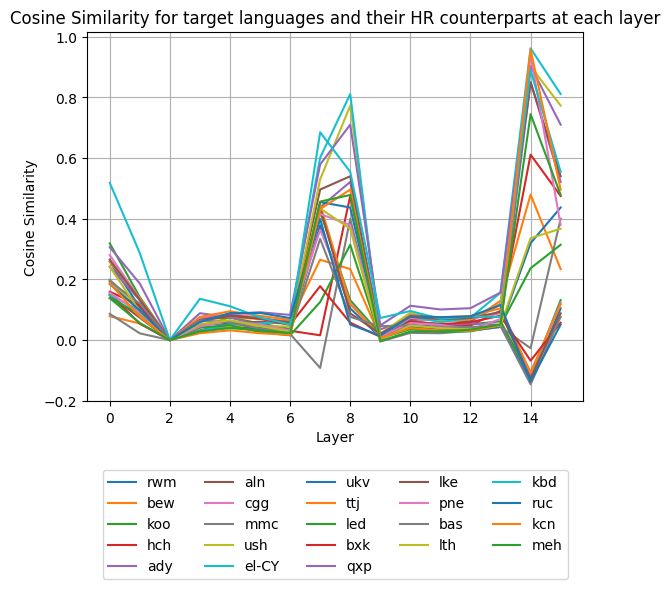

In [26]:
import matplotlib.pyplot as plt
# Plotting all lines at once
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed
mse_graph = [(lang, item["layer_wise_cossim"]) for lang, item in lang_hr_gains.items()]
xs = range(len(mse_graph[0][1]))
ys = np.array([smooth(v[1], 0.9) for v in mse_graph]).T
ys = np.array([v[1]for v in mse_graph]).T

labels = [v[0] for v in mse_graph]

fig, ax = plt.subplots()

ax.plot(xs, ys, label=labels)

# Adding labels and legend (you would need to manually create labels here if desired)
ax.set_xlabel('Layer')
ax.set_ylabel('Cosine Similarity')
# ax.set_yscale("log")
ax.set_title('Cosine Similarity for target languages and their HR counterparts at each layer')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=5) 
ax.grid(True)
plt.show()


In [100]:
import pandas as pd
import json
import os
from sklearn.metrics.pairwise import cosine_similarity

model = "results/whisper-tiny"
rows = []
summary_df = pd.read_csv(f"{model}/summary.csv")
token_freq_df = pd.read_csv("token_frequency/measures.tsv", delimiter="\t")
lang_hr_gains = {}
for result in os.listdir(f"{model}/hyperparameters"):
    with open(f"{model}/hyperparameters/" + result, "r") as f:
        hyps = json.load(f)
        f.close()
    if len(hyps) > 0:
        lang_name = result.split(".")[0]
        lang_hr_gains[lang_name] = {}
        best_score = hyps[min(hyps, key=hyps.get)]#summary_df.loc[summary_df['language'] == lang_name]["wer"]
        best_lambda = min(hyps, key=hyps.get)
        score_0 = hyps["0.0"]
        lang_hr_gains[lang_name]["lambda"] = float(best_lambda)
        lang_hr_gains[lang_name]["hr_delta"] = float(abs(score_0 - best_score))
        lang_hr_gains[lang_name]["wer"] = score_0
        # language_tv = TVs[lang_name]
        # hr_tv = TVs["_".join(HR_MAP[lang_name])]
        # hr_tv = TVs["_".join(HR_MAP[lang_name])]
        # cossim = cosine_similarity(language_tv.tv_to_vector().reshape(1, -1), hr_tv.tv_to_vector().reshape(1, -1))[0][0]
        # lang_hr_gains[lang_name]["tv_cossim"] = cossim
df = pd.DataFrame(lang_hr_gains).T
df.rename_axis("lang", inplace=True)
df = df.reset_index()
merged_df =pd.merge(df, token_freq_df,on="lang")
merged_df

,lang,lambda,hr_delta,wer,cosine,rho_p,rho_p_p,rho_s,rho_s_p,T_k,T_k_p
0,rwm,0.075991,0.051132,0.831934,0.447021,0.445685,0.0,0.425552,0.0,0.412273,0.0
1,bew,0.122665,0.036415,0.707431,0.605119,0.603796,0.0,0.472543,0.0,0.456169,0.0
2,koo,0.060808,0.015245,0.900038,0.637674,0.636584,0.0,0.415877,0.0,0.403323,0.0
3,hch,0.136166,0.039586,0.760387,0.201821,0.200954,0.0,0.410601,0.0,0.403161,0.0
4,ady,0.033981,0.015840,0.836154,0.306326,0.305788,0.0,0.383031,0.0,0.379230,0.0
5,aln,0.186599,0.030039,0.706040,0.272323,0.271530,0.0,0.528206,0.0,0.517312,0.0
6,cgg,0.049134,0.082974,0.692151,0.755091,0.754403,0.0,0.419346,0.0,0.407039,0.0
7,mmc,0.055610,0.002233,0.779746,0.271928,0.271161,0.0,0.372030,0.0,0.367553,0.0
8,ush,0.036769,0.008745,0.583770,0.859920,0.859788,0.0,0.693856,0.0,0.692468,0.0
9,el-CY,0.051830,0.012531,0.770213,0.704205,0.703585,0.0,0.811478,0.0,0.809686,0.0


cosine_similarity predictor for delta
R-squared: 0.2700238966886592
spearman SignificanceResult(statistic=0.38142292490118584, pvalue=0.07252253296442937)
pearson PearsonRResult(statistic=0.5196382363612777, pvalue=0.011043684787808969)
cosine similarity predictor for lambda
R-squared: 0.06392634076202164
spearman SignificanceResult(statistic=0.0800395256916996, pvalue=0.7165801831888988)
pearson PearsonRResult(statistic=0.2528365890491751, pvalue=0.24443434633275635)
cosine similarity predictor for wer
R-squared: 0.012781418626050978
spearman SignificanceResult(statistic=0.14723320158102768, pvalue=0.5026048124293907)
pearson PearsonRResult(statistic=0.1130549363188135, pvalue=0.6075260721518073)


<Axes: xlabel='cosine', ylabel='lambda'>

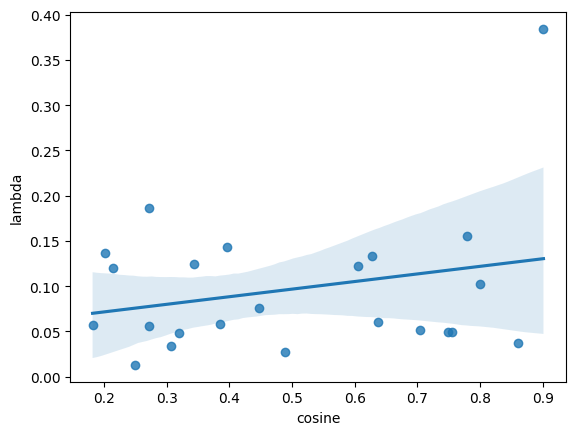

In [104]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np

import seaborn
cossim = np.array(merged_df.cosine)
delta = np.array(merged_df.hr_delta)
wer = np.array(merged_df.wer)
model = LinearRegression()
model.fit(delta.reshape(-1,1), cossim)
pred = model.predict(delta.reshape(-1,1))
# Calculate R-squared
r2 = r2_score(cossim, pred)
spearman = spearmanr(cossim, delta)
pearson = pearsonr(cossim, delta)
print("cosine_similarity predictor for delta")
print(f"R-squared: {r2}")
print("spearman", spearman)
print("pearson", pearson)

lamb = np.array(merged_df["lambda"])
model = LinearRegression()
model.fit(lamb.reshape(-1,1), cossim)
pred = model.predict(lamb.reshape(-1,1))
# Calculate R-squared
r2 = r2_score(cossim, pred)
spearman = spearmanr(cossim, lamb)
pearson = pearsonr(cossim, lamb)
print("cosine similarity predictor for lambda")
print(f"R-squared: {r2}")
print("spearman", spearman)
print("pearson", pearson)

wer = np.array(merged_df["wer"])
model = LinearRegression()
model.fit(wer.reshape(-1,1), cossim)
pred = model.predict(wer.reshape(-1,1))
# Calculate R-squared
r2 = r2_score(cossim, pred)
spearman = spearmanr(cossim, wer)
pearson = pearsonr(cossim, wer)
print("cosine similarity predictor for wer")
print(f"R-squared: {r2}")
print("spearman", spearman)
print("pearson", pearson)


seaborn.regplot(data=merged_df, x="cosine", y="lambda")

<Axes: xlabel='cosine', ylabel='hr_delta'>

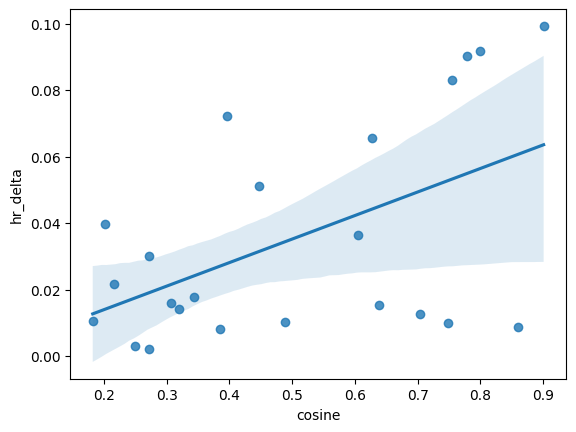

In [86]:
seaborn.regplot(data=merged_df, x="cosine", y="hr_delta")

TV cosine similarity predictor for token cossim
R-squared: 0.0056954691737355345
spearman SignificanceResult(statistic=-0.23221343873517786, pvalue=0.28632757233033423)


<Axes: xlabel='tv_cossim', ylabel='cosine'>

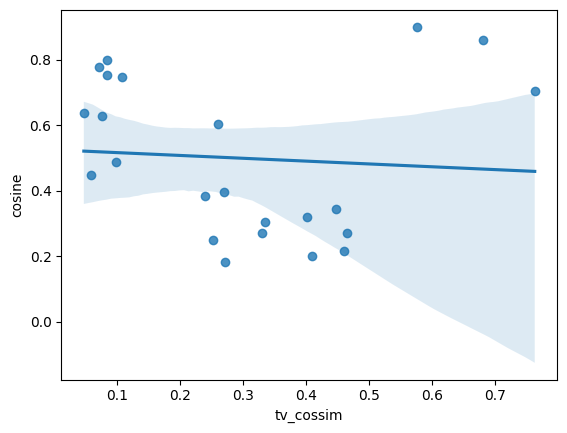

In [87]:
tv_cossim = np.array(merged_df["tv_cossim"])
cossim = np.array(merged_df.cosine)

model = LinearRegression()
model.fit(tv_cossim.reshape(-1,1), cossim)
pred = model.predict(tv_cossim.reshape(-1,1))
# Calculate R-squared
r2 = r2_score(cossim, pred)
spearman = spearmanr(cossim, tv_cossim)
print("TV cosine similarity predictor for token cossim")
print(f"R-squared: {r2}")
print("spearman", spearman)

seaborn.regplot(data=merged_df, x="tv_cossim", y="cosine")

In [98]:
import pandas as pd
import json
import os
from sklearn.metrics.pairwise import cosine_similarity

model = "results/whisper-large-v3"
rows = []
summary_df = pd.read_csv(f"{model}/summary.csv")
token_freq_df = pd.read_csv("token_frequency/measures.tsv", delimiter="\t")
lang_hr_gains = {}
for result in os.listdir(f"{model}/hyperparameters"):
    with open(f"{model}/hyperparameters/" + result, "r") as f:
        hyps = json.load(f)
        f.close()
    if len(hyps) > 0:
        lang_name = result.split(".")[0]
        lang_hr_gains[lang_name] = {}
        best_score = hyps[min(hyps, key=hyps.get)]#summary_df.loc[summary_df['language'] == lang_name]["wer"]
        best_lambda = min(hyps, key=hyps.get)
        score_0 = hyps["0.0"]
        lang_hr_gains[lang_name]["lambda"] = float(best_lambda)
        lang_hr_gains[lang_name]["hr_delta"] = float(abs(score_0 - best_score))
        lang_hr_gains[lang_name]["wer"] = score_0
        # language_tv = TVs[lang_name]
        # hr_tv = TVs["_".join(HR_MAP[lang_name])]
        # hr_tv = TVs["_".join(HR_MAP[lang_name])]
        # cossim = cosine_similarity(language_tv.tv_to_vector().reshape(1, -1), hr_tv.tv_to_vector().reshape(1, -1))[0][0]
        # lang_hr_gains[lang_name]["tv_cossim"] = cossim
df = pd.DataFrame(lang_hr_gains).T
df.rename_axis("lang", inplace=True)
df = df.reset_index()
merged_df =pd.merge(df, token_freq_df,on="lang")
merged_df
wer = np.array(merged_df["wer"])
hr_delta = np.array(merged_df["hr_delta"])
model = LinearRegression()
model.fit(hr_delta.reshape(-1,1), wer)
pred = model.predict(hr_delta.reshape(-1,1))
# Calculate R-squared
r2 = r2_score(wer, pred)
spearman = spearmanr(wer, hr_delta)
pearson = pearsonr(wer, hr_delta)
print("wer predictor for delta")
print(f"R-squared: {r2}")
print("spearman", spearman)
print("pearson", pearson)

wer predictor for delta
R-squared: 0.6021214335416472
spearman SignificanceResult(statistic=0.5970059033655146, pvalue=0.002633923164766342)
pearson PearsonRResult(statistic=0.7759648404029962, pvalue=1.3534759785548109e-05)
